# QMBS

In [135]:
import numpy as np
from qutip import *
from matplotlib import pyplot as plt
import scipy.sparse as sparse
from scipy.signal import find_peaks

N=16

In [2]:
def Z_2(N):
    statelist = ([basis(2,1)] + [basis(2,0)]) * int(L/2)
    return tensor(statelist)

In [3]:
def genPsi0(L):
    if L%4 == 0:
        state_list = ([basis(2, 1)] + [basis(2, 0)] + [basis(2, 0)] + [basis(2, 1)]) * (int(L/4))
    else:
        state_list = ([basis(2, 1)] + [basis(2, 0)] + [basis(2, 0)] + [basis(2, 1)]) * (int(L/4))+ ([basis(2, 1)] + [basis(2, 0)])
    state_thermal = (([basis(2,1)] + [basis(2,0)]) * int(L/2))
    psi0 = tensor(state_list)
    psi_thermal = tensor(state_thermal)
    return psi0, psi_thermal


In [4]:
def genHamiltonian(L):
    
    omega = 0.05 * np.pi * np.ones(L)

    # Interaction coefficients
    Ja = 0.3 * np.pi * np.ones(L)
    Je = 0.2 * np.pi * np.ones(L)
    Jx = 0.03 * np.pi * np.ones(L)
    
    sx_list, sy_list, sz_list, sm_list, sp_list = [], [], [], [], []
    
    for i in range(L):
        op_list = [qeye(2)] * L
        op_list[i] = sigmax()
        sx_list.append(tensor(op_list))
        op_list[i] = sigmay()
        sy_list.append(tensor(op_list))
        op_list[i] = sigmaz()
        sz_list.append(tensor(op_list))
        op_list[i] = sigmap()
        sp_list.append(tensor(op_list))
        op_list[i] = sigmam()
        sm_list.append(tensor(op_list))

    # Hamiltonian - transition frequenmcy term
    H = 0
    for i in range(L):
        H += 0.5 * omega[i] * sp_list[i]*sm_list[i]

    # Interaction terms
    for n in range(L - 1):
        if n%2 ==0:
            H += -0.5 * Ja[n] * sp_list[n] * sm_list[n + 1]
            H += -0.5 * Ja[n] * sm_list[n] * sp_list[n + 1]
        else:
            H += -0.5 * Je[n] * sp_list[n] * sm_list[n + 1]
            H += -0.5 * Je[n] * sm_list[n] * sp_list[n + 1]

    # Cross coupling terms
    #for n in range(N):
       # H += -0.5 * Jx[n] * sp_list[n] * sm_list[(n + 4)%N]
       # H += -0.5 * Jx[n] * sm_list[n] * sp_list[(n + 4)%N]
    
    return H


In [5]:
def Jij(J0,Alpha,N):
    J_ij = []
    for i,j in range(N):
        if i >j:
            J_ij.append(J0/(i-j)**Alpha)
    return J_ij

In [6]:
def plotEntropy(results):
    for result in results:
        entropy = []
        for Psi_T in result.states:
            rho = ptrace(Psi_T,[0,1,2,3])
            entropy.append(entropy_vn(rho))
        plt.plot(entropy)
    plt.xlabel('timesteps')
    plt.ylabel('VN Entropy')
    

In [7]:
def plotFidelity(results):
    for result in results:
        rho0 = ptrace(result.states[0],[0,1,2,3])
        fidelitylist = []
        for Psi_T in result.states:
            rho = ptrace(Psi_T,[0,1,2,3])
            fidelitylist.append(fidelity(rho0,rho))
        plt.plot(fidelitylist)
    plt.xlabel('timesteps')
    plt.ylabel('Fidelity')

In [94]:
times = np.linspace(0,25,100)
results =[]
results_t = []
for systemLength in [16]:
    H = genHamiltonian(systemLength)
    psi0, psi_thermal = genPsi0(systemLength)
    result = sesolve(H,psi0,times)
    resultsThermal = sesolve(H,psi_thermal,times)
    results.append(result)
    results_t.append(resultsThermal)

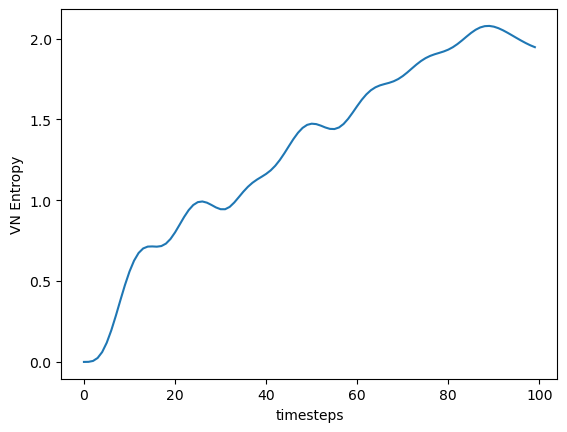

In [137]:
plotEntropy(results)

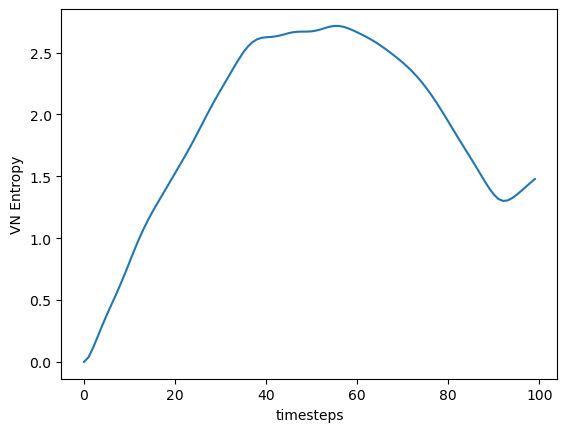

In [10]:
plotEntropy(results_t)

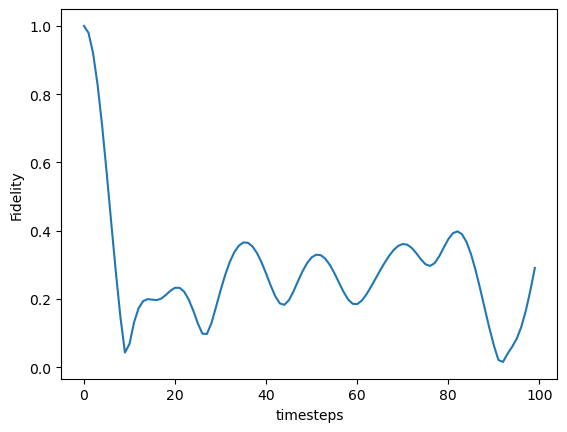

In [11]:
plotFidelity(results_t)

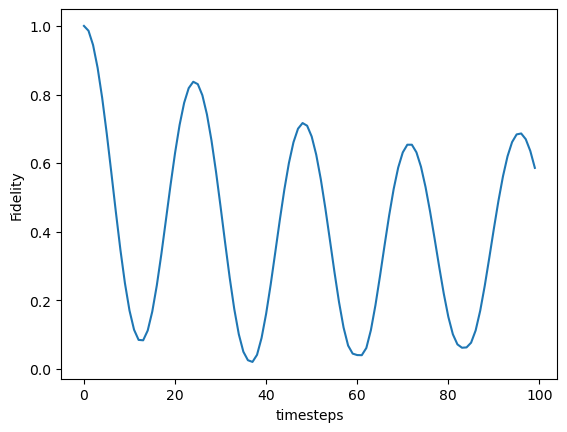

In [12]:
plotFidelity(results)

In [13]:
VNEntropy=[]
thermalVN = []
thermalfidelity=[]
fourfidelity = []
rho0=ptrace(psi0,[0,1,2,3])
rho0_thermal = ptrace(psi_thermal,[0,1,2,3])
for Psi_T in result.states:
    rho=ptrace(Psi_T,[0,1,2,3])
    VNEntropy.append(entropy_vn(rho))
    fourfidelity.append(fidelity(rho0,rho))
for Psi_T in resultsThermal.states:
    rho=ptrace(Psi_T,[0,1,2,3])
    thermalVN.append(entropy_vn(rho))
    thermalfidelity.append(fidelity(rho0_thermal,rho))
    

In [14]:
sz_list =[]
for i in range(N):
        op_list = [qeye(2)] * N
        op_list[i] = sigmaz()
        sz_list.append(tensor(op_list))

In [15]:
exp_sz_t_scar = expect(sz_list, result.states)
exp_sz_0_scar = expect(sz_list,psi0)
exp_sz_t2_scar=[]
for i in range(len(exp_sz_0_scar)):
    exp_sz_t2_scar.append(exp_sz_0_scar[i]*exp_sz_t_scar[i])
imbalance =  1/N* sum(exp_sz_t2_scar)

In [16]:
exp_sz_t_thermal = expect(sz_list, resultsThermal.states)
exp_sz_0_thermal = expect(sz_list,psi_thermal)
exp_sz_t2_thermal=[]
for i in range(len(exp_sz_0_thermal)):
    exp_sz_t2_thermal.append(exp_sz_0_thermal[i]*exp_sz_t_thermal[i])
imbalance_thermal =  1/N* sum(exp_sz_t2_thermal)

In [17]:
fidelitylist = []
thermalfullFidelity= []

for i in range(len(result.times)):
    fidelitylist.append(np.vdot(result.states[0],result.states[i])*np.conj(np.vdot(result.states[0],result.states[i])))
    thermalfullFidelity.append(np.vdot(resultsThermal.states[0],resultsThermal.states[i])*np.conj(np.vdot(resultsThermal.states[0],resultsThermal.states[i])))

C:\Users\Charlie\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


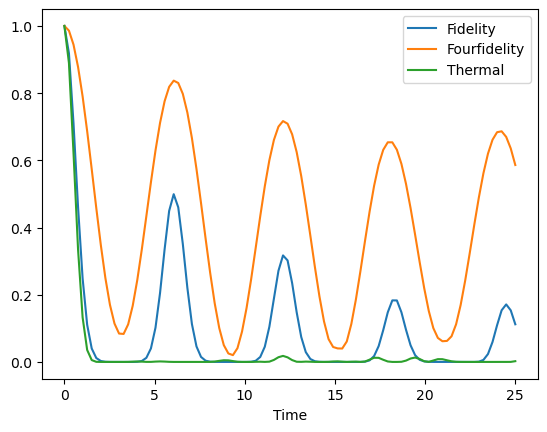

In [18]:
plt.plot(times,fidelitylist,label = 'Fidelity')
plt.plot(times,fourfidelity,label='Fourfidelity')
plt.plot(times, thermalfullFidelity,label='Thermal')
plt.xlabel('Time')
plt.legend()


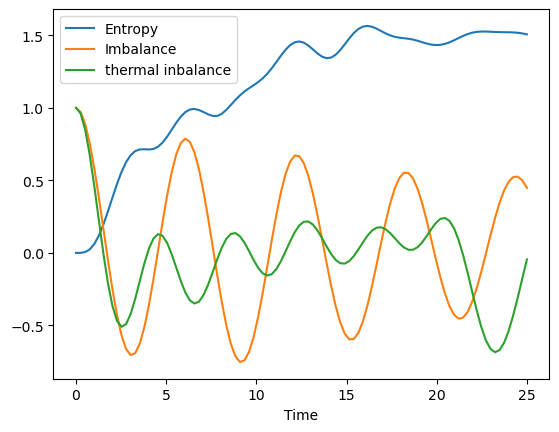

In [19]:
plt.plot(times,VNEntropy,label = 'Entropy')
plt.plot(times,imbalance, label = 'Imbalance')
plt.plot(times,imbalance_thermal, label = 'thermal inbalance')
plt.xlabel('Time')
plt.legend()

In [20]:
from scipy.fft import fft,fftfreq

In [21]:
intensity_imbalance = fft(imbalance,n=400)

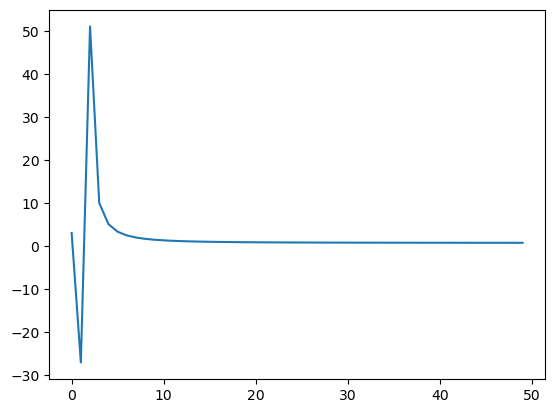

In [22]:
plt.plot(intensity_imbalance[:50])

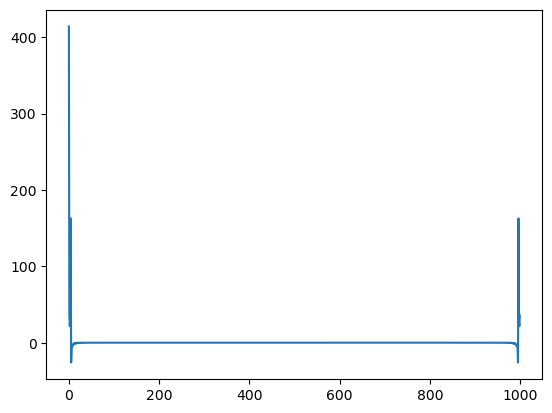

In [23]:
intensity_fidelity = fft(fourfidelity)
plt.plot(intensity_fidelity)

In [24]:
vals, vecs = sparse.linalg.eigsh(H.data,k=500, which = 'SA')

KeyboardInterrupt: 

In [ ]:
overlap = []
for i in range(4096):
    overlap.append(np.log10((np.abs(np.vdot(psi0,eigvecs[i])*np.conj(np.vdot(psi0,eigvecs[i])))**2)))

In [ ]:
plt.scatter(eigvals,overlap)

In [ ]:
plt.scatter(eigvals,fqis)

In [ ]:
eigvecs

In [ ]:
eigvals, eigvecs = H.eigenstates(sparse=True, sort='low', eigvals=0, tol=0, maxiter=100000)

In [ ]:
EigenEntropy =[]
for i in range(len(vecs)):
    EigenEntropy.append(entropy_vn(ptrace(vecs[:,i], (range(int(N/2))))))
                        
    

In [ ]:
plt.scatter(eigenvalues,EigenEntropy)

In [20]:
import random
def randhalffilledstate(N):
    basislist=[]
    for i in range(2**N):
        x= format(i,'0{n}b'.format(n=N))
        total = sum(int(a) for a in x)
        if total == N/2:
            basislist.append(i)
    ket = np.zeros(2**N)
    for index in basislist:
        ket[index] += np.random.rand()+np.random.rand()*1j
    return Qobj(ket)
        

In [21]:
def randstate(N):
    basislist=[]
    for i in range(2**N):
        x= format(i,'0{n}b'.format(n=N))
        total = sum(int(a) for a in x)
        if total == N/2:
            basislist.append(i)
    ket = np.zeros(2**N)
    j = random.randint(0,len(basislist))
    ket[basislist[j]] = 1
    return Qobj(ket)

In [48]:
def GenOperators(N):
    sJK_list=[]
    sJlist = []
    for z in range(N):
        op_list = [qeye(2)]*N
        if (z+1)%4 not in [0,1]:
            op_list[z]= sigmaz()
        else:
            op_list[z] = -1*sigmaz()
        sJlist.append(tensor(op_list))
    for j in range(N):
        for k in range(N):
            op_list = [qeye(2)] * N
            if j>k:
                if (j+1)%4 not in [0,1]:
                    op_list[j]= sigmaz()
                else:
                    op_list[j] = -1*sigmaz()
                if (j+1)%4 not in [0,1]:
                    op_list[k]= sigmaz()
                else:
                    op_list[k] = -1*sigmaz()
                sJK_list.append(tensor(op_list))
    return sJK_list, sJlist
def QFI(states,N):
    SJK,SJ = GenOperators(N)
    FQIS = []
    for state in states:
        FQI = 4 * (sum(expect(SJK,state))-sum(expect(SJ,state))**2)
        FQIS.append(FQI/N)
    return FQIS

In [96]:
random_ket = randstate(N).unit()
random_ket.dims = psi0.dims

In [97]:
logtimes = np.linspace(1000,100000,1000)
timesstart = np.linspace(0,10000,1000)
randresults = sesolve(H,random_ket,timesstart, options=Options(nsteps=10000))

In [98]:
sJKlist,sJlist = GenOperators(N)
SJexpect = sum(expect(sJlist,result.states))
SJKexpect = sum(expect(sJKlist, result.states))
SJTexpect = sum(expect(sJlist, results_t[0].states))
SJrand = sum(expect(sJlist, randresults.states))

In [99]:
sj = sum(sJlist)

In [100]:
longresult = sesolve(H,psi0,timesstart, options=Options(nsteps=10000))

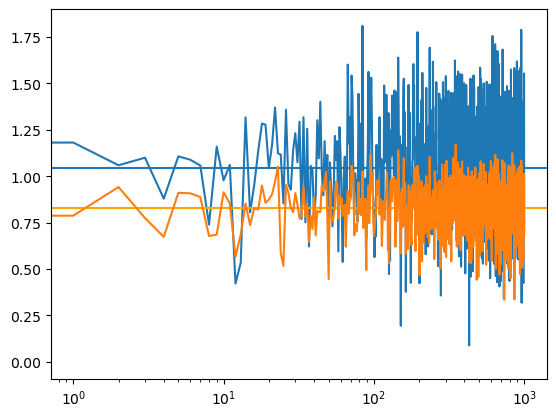

In [166]:
#fqit= variance(sj,results_t[0].states)
fqir = variance(sj,randresults.states)/N
fqi = variance(sj,longresult.states)/N
plt.plot(fqi)
plt.axhline(y=np.nanmean(fqir), color='orange')
plt.axhline(y=np.nanmean(fqi))
#plt.plot(fqit)
plt.plot(fqir)
plt.xscale('log')


In [63]:
VarZ = 0
for i in range(len(sJlist)):
    VarZ += variance(sJlist[i],result.states)

In [49]:
FQI = QFI(result.states,N)
FQIT = QFI(resultsThermal.states,N)
FQIR = QFI(randresults.states,N)

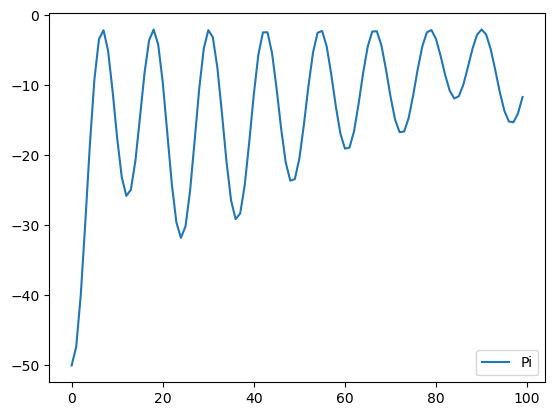

In [51]:
plt.plot(FQI, label = 'Pi')
#plt.plot(FQIT, label = 'Z_2')
#plt.plot(timesstart, FQIR, label = 'random')
plt.legend()

In [103]:
basislist=[]
basisbinary = []
for i in range(2**N):
    x= format(i,'0{n}b'.format(n=N))
    total = sum(int(a) for a in x)
    if total == N/2:
        basislist.append(i)
        basisbinary.append(x)

In [104]:
h2 = H.extract_states(basislist)

In [105]:
eigval2, eigvecs2 = h2.eigenstates(sparse=True, sort='low', eigvals=0, tol=0, maxiter=100000)

In [106]:
psi0_reduced = psi0.extract_states(basislist)

In [126]:
fidels = []
for i in range(len(basislist)):
    fidels.append(abs(eigvecs2[i].overlap(psi0_reduced)**2))

(1e-07, 0.08818749806912596)

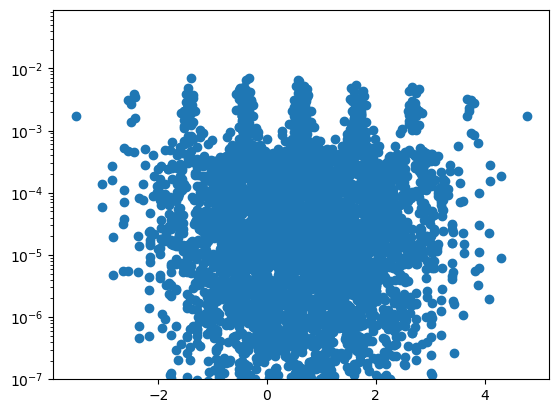

In [160]:
plt.scatter(eigval2,fidels)
plt.yscale('log')
plt.ylim(bottom = 10**-7)

In [133]:
FQI_eigenvectors = []
for state in eigvecs2:
    FQI_eigenvectors.append(4*variance(sj,state)/N)

Exception: Operator and state do not have same tensor structure: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] and [12870]

In [47]:
def expec(operator, sites, staggered, basis):
    # Creates list of operator acting on each site
    a=[]
    for j in range(sites):
        temp_array=np.zeros((len(basis)))
        for i, basis_element in enumerate(basis):

            if operator == 'Z':
                if basis_element[j] == '0':
                    temp_array[i] = (-1)
                else:
                    temp_array[i] = (1)
            if operator == 'y':
                if basis_element[j] == '0':
                    temp_array[i] = (-1j)
                else:
                    temp_array[i] = (1j)
            if staggered == True:
                if (j+1)%4 not in [0,1]:
                    for k in range(len(temp_array)):
                        temp_array[k] = (-1)*temp_array[k]
        a.append(temp_array)
    return a
def actexpec(operatorlist, psi):
    psi_2 = psi.data[:] # copies the psi data to not overwrite it. 
    for operator in operatorlist:   # for each operator ie s^z_site, 
        for i in range(psi_2.shape[0]):   
            psi_2[i]  = psi_2[i]*operator[i]
    return psi_2

In [36]:
Z = expec('Z',N,False,basisbinary)
c = actexpec(Z, psi0_reduced)

In [97]:
c.H

<1x924 sparse matrix of type '<class 'numpy.complex128'>'
	with 1 stored elements in Compressed Sparse Row format>

In [49]:
sparse.find(c)

(array([0], dtype=int32), array([0], dtype=int32), array([-2.+0.j]))

In [45]:
fqiZ =[]
fqiZStaggered = []
Z = expec('Z',N,False,basisbinary)
StaggeredZ = expec('Z',N,True,basisbinary)
for state in result.states[:100]:
    c = actexpec(Z, state.extract_states(basislist))
    Zstate = c.H @ state.extract_states(basislist).data
    fqiZ.append(Zstate.data)
    d = actexpec(StaggeredZ, state.extract_states(basislist))
    Zstagstate = d.H @ state.extract_states(basislist).data
    fqiZStaggered.append(Zstagstate.data)

In [138]:
h2

Quantum object: dims = [[12870], [12870]], shape = (12870, 12870), type = oper, isherm = True
Qobj data =
  (0, 0)	(0.6283185307179586+0j)
  (0, 1)	(-0.3141592653589793+0j)
  (1, 0)	(-0.3141592653589793+0j)
  (1, 1)	(0.6283185307179586+0j)
  (1, 2)	(-0.47123889803846897+0j)
  (1, 9)	(-0.47123889803846897+0j)
  (2, 1)	(-0.47123889803846897+0j)
  (2, 2)	(0.6283185307179586+0j)
  (2, 3)	(-0.3141592653589793+0j)
  (2, 10)	(-0.47123889803846897+0j)
  (3, 2)	(-0.3141592653589793+0j)
  (3, 3)	(0.6283185307179586+0j)
  (3, 4)	(-0.47123889803846897+0j)
  (3, 11)	(-0.47123889803846897+0j)
  (4, 3)	(-0.47123889803846897+0j)
  (4, 4)	(0.6283185307179586+0j)
  (4, 5)	(-0.3141592653589793+0j)
  (4, 12)	(-0.47123889803846897+0j)
  (5, 4)	(-0.3141592653589793+0j)
  (5, 5)	(0.6283185307179586+0j)
  (5, 6)	(-0.47123889803846897+0j)
  (5, 13)	(-0.47123889803846897+0j)
  (6, 5)	(-0.47123889803846897+0j)
  (6, 6)	(0.6283185307179586+0j)
  (6, 7)	(-0.3141592653589793+0j)
  :	:
  (12863, 12862)	(-0.314159265

In [140]:
eigvecs2[0]

Quantum object: dims = [[12870], [1]], shape = (12870, 1), type = ket
Qobj data =
  (2, 0)	3.913162351350193e-12j
  (3, 0)	(1.8422589421601567e-12+1.6439509314259936e-11j)
  (4, 0)	(3.92175217010023e-12+3.499626114604885e-11j)
  (5, 0)	(8.585503934903547e-12+7.661392599707924e-11j)
  (6, 0)	(1.1369151265587664e-11+1.0145411442603853e-10j)
  (7, 0)	(1.2727728597846041e-11+1.13577556428816e-10j)
  (8, 0)	(9.709776514018978e-12+8.66465242927584e-11j)
  (9, 0)	3.9131657382618e-12j
  (10, 0)	(2.5279698816063863e-12+2.2558694523187627e-11j)
  (11, 0)	(1.1987111563835003e-11+1.0696847059078227e-10j)
  (12, 0)	(2.692303581849909e-11+2.4025109755398434e-10j)
  (13, 0)	(6.151967143242236e-11+5.489786082129532e-10j)
  (14, 0)	(8.291276247810252e-11+7.398826014251471e-10j)
  (15, 0)	(9.464190969988448e-11+8.445491243066508e-10j)
  (16, 0)	(7.266276076003138e-11+6.484154151265093e-10j)
  (17, 0)	(8.057748628480678e-12+7.190436091031626e-11j)
  (18, 0)	(5.188254527080407e-11+4.6298039896038355e-10j)

In [151]:
psi0.data.nonzero()

(array([39321]), array([0]))

In [172]:
spacing = []
eigenvalues = eigenvals
for i in range(int(0.2*len(eigenvalues)),int(0.8*len(eigenvalues))):
    space = eigenvalues[i+1] - eigenvalues[i]
    if space != 0:
        spacing.append(eigenvalues[i+1] - eigenvalues[i])
S_i = spacing/np.mean(spacing)

NameError: name 'eigenvals' is not defined

(array([5.927e+03, 6.180e+02, 2.480e+02, 1.980e+02, 7.000e+01, 6.600e+01,
        3.200e+01, 5.200e+01, 5.800e+01, 6.400e+01, 1.400e+01, 3.800e+01,
        5.400e+01, 7.600e+01, 2.400e+01, 1.400e+01, 6.000e+00, 4.000e+00,
        2.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 2.000e+00]),
 array([2.65771191e-14, 9.31871168e-01, 1.86374234e+00, 2.79561350e+00,
        3.72748467e+00, 4.65935584e+00, 5.59122701e+00, 6.52309817e+00,
        7.45496934e+00, 8.38684051e+00, 9.31871168e+00, 1.02505828e+01,
        1.11824540e+01, 1.21143252e+01, 1.30461963e+01, 1.39780675e+01,
        1.49099387e+01, 1.58418099e+01, 1.67736810e+01, 1.77055522e+01,
        1.86374234e+01, 1.95692945e+01, 2.05011657e+01, 2.14330369e+01,
        2.23649080e+01, 2.32967792e+01, 2.42286504e+01, 2.51605215e+01,
        2.60923927e+01, 2.70242639e+01, 2.79561350e+01]),
 <BarContainer object of 30 artists>)

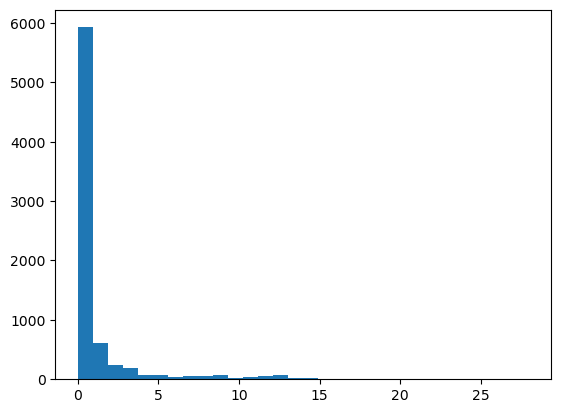

In [168]:
plt.hist(S_i,30)